# Enterprise-Grade Telecom Data Analysis Notebook

This notebook demonstrates an improved analysis workflow that incorporates practices used in large organizations.

The notebook includes:
- Data Quality & Governance Checks
- Advanced Exploratory Data Analysis (EDA)
    - Univariate Analysis (distribution fitting, normality tests, outlier detection)
    - Bivariate & Multivariate Analysis (correlation significance, pair plots, PCA)
- Time Series Analysis & Forecasting using Prophet (including seasonal decomposition and ACF/PACF)
- Advanced Predictive Modeling with Pipelines, Cross-Validation, and MLflow Logging
- Enhanced Clustering & Segmentation with Silhouette Score
- Anomaly Detection & Impact Analysis
- Interactive Dashboard Prototyping with Plotly

**Note:** In production, data would be loaded from enterprise data lakes/warehouses, and distributed processing (e.g., Spark)
would be used. This notebook serves as a prototype.

**Note:** In a production system, you would use distributed data processing frameworks (like Apache Spark or Dask) and robust ETL pipelines,
      along with data governance tools and real-time dashboards. This notebook serves as a prototype for such systems.


In [ ]:
import pandas as pd
import numpy as np
import datetime
import matplotlib.pyplot as plt
import seaborn as sns
import scipy.stats as stats

from sklearn.ensemble import RandomForestRegressor, IsolationForest
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import mean_squared_error, silhouette_score
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans

# For time series forecasting using Prophet
from prophet import Prophet
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

# For experiment tracking (MLflow)
import mlflow
import mlflow.sklearn

# For interactive dashboards
import plotly.express as px

# For reproducibility
np.random.seed(42)

## 0. Data Ingestion and Quality Checks
 
Here we simulate loading the FactTable and TimeDimension (as before) and perform data quality checks.
In production, you’d load data from data lakes/warehouses (e.g., Snowflake, BigQuery) using robust connectors.

In [2]:
# # Simulated FactTable (expanded sample size for demonstration; in production, this could be millions of rows)
# num_fact_records = 5000

# fact_data = {
#     'FactID': np.arange(1, num_fact_records+1),
#     'CustomerID': np.random.randint(1, 1001, num_fact_records),
#     'TimeID': np.random.randint(1, 2001, num_fact_records),
#     'LocationID': np.random.randint(1, 62, num_fact_records),
#     'NetworkTypeID': np.random.randint(1, 4, num_fact_records),
#     'CustomerSegmentID': np.random.randint(1, 6, num_fact_records),
#     'Uptime': np.random.uniform(95, 100, num_fact_records).round(2),
#     'CallDropRate': np.random.uniform(0.5, 3.0, num_fact_records).round(2),
#     'Latency': np.random.uniform(20, 100, num_fact_records).round(2),
#     'Throughput': np.random.uniform(50, 300, num_fact_records).round(2),
#     'SignalStrength': np.random.uniform(-90, -50, num_fact_records).round(2),
#     'DataErrorRate': np.random.uniform(0, 1, num_fact_records).round(2),
#     'PacketLoss': np.random.uniform(0, 2, num_fact_records).round(2),
#     'Jitter': np.random.uniform(0, 10, num_fact_records).round(2),
#     'NetworkAvailability': np.random.uniform(95, 100, num_fact_records).round(2),
#     'DataUsage': np.random.uniform(100, 5000, num_fact_records).round(2),
#     'NumberOfCalls': np.random.randint(0, 51, num_fact_records),
#     'NumberOfTexts': np.random.randint(0, 101, num_fact_records),
#     'SessionDuration': np.random.uniform(60, 3600, num_fact_records).round(2),
#     'CustomerSatisfaction': np.random.uniform(1, 5, num_fact_records).round(2),
#     'ChurnRiskIndicator': np.random.uniform(0, 100, num_fact_records).round(2),
#     'ARPU': np.random.uniform(10, 100, num_fact_records).round(2),
#     'ComplaintRate': np.random.uniform(0, 5, num_fact_records).round(2),
#     'ServiceActivationCount': np.random.randint(0, 6, num_fact_records),
#     'ServiceDeactivationCount': np.random.randint(0, 4, num_fact_records),
#     'HandlingTime': np.random.uniform(1, 30, num_fact_records).round(2),
#     'NPS': np.random.uniform(-100, 100, num_fact_records).round(2),
#     'Revenue': np.random.uniform(10, 1000, num_fact_records).round(2)
# }
# df_fact = pd.DataFrame(fact_data)
# df_fact['Downtime'] = (100 - df_fact['Uptime']).round(2)

# Simulated TimeDimension table
# time_ids = np.arange(1, 2001)
# start_date = datetime.datetime(2018, 1, 1)
# timestamps = [start_date + datetime.timedelta(hours=i) for i in range(2000)]
# df_time = pd.DataFrame({
#     'TimeID': time_ids,
#     'Timestamp': timestamps,
#     'FullDate': [ts.date() for ts in timestamps],
#     'Year': [ts.year for ts in timestamps],
#     'Quarter': [((ts.month-1)//3)+1 for ts in timestamps],
#     'Month': [ts.month for ts in timestamps],
#     'Day': [ts.day for ts in timestamps],
#     'Hour': [ts.hour for ts in timestamps]
# })

In [3]:
df_fact = pd.read_excel("Telecoms Data.xlsx", sheet_name= "FactTable")
df_fact = df_fact[df_fact['Date'].dt.year >= pd.Timestamp.now().year - 1]

df_fact = df_fact.assign(
    FullDate=df_fact['Timestamp'].dt.date,
    Year=df_fact['Timestamp'].dt.year,
    Quarter=((df_fact['Timestamp'].dt.month - 1) // 3) + 1,
    Month=df_fact['Timestamp'].dt.month,
    Day=df_fact['Timestamp'].dt.day,
    Hour=df_fact['Timestamp'].dt.hour
)

# Merge fact table with time dimension
# df_fact_time = pd.merge(df_fact, df_time, on='TimeID', how='left')

# Data Quality Checks
print("Missing Values in FactTable:")
print(df_fact.isnull().sum())
print("\nDuplicates in FactTable:", df_fact.duplicated().sum())

# Outlier check (for a few key metrics)
print("\nOutlier Summary (Latency):")
print(df_fact['Latency'].describe())

Missing Values in FactTable:
FactID                      0
CustomerID                  0
Timestamp                   0
LocationID                  0
NetworkTypeID               0
CustomerSegmentID           0
Uptime                      0
Downtime                    0
CallDropRate                0
Latency                     0
Throughput                  0
SignalStrength              0
DataErrorRate               0
PacketLoss                  0
Jitter                      0
NetworkAvailability         0
DataUsage                   0
NumberOfCalls               0
NumberOfTexts               0
SessionDuration             0
CustomerSatisfaction        0
ChurnRiskIndicator          0
ARPU                        0
ComplaintRate               0
ServiceActivationCount      0
ServiceDeactivationCount    0
HandlingTime                0
NPS                         0
Revenue                     0
Date                        0
Time                        0
FullDate                    0
Year       

### Inference

The "Outlier Summary (Latency)" results provide key statistical information about the latency measurements in our dataset. 
Count (16,053):
There are 16,053 latency measurements in the dataset.

Mean (≈60.02 ms):
On average, the network latency is about 60 milliseconds. This gives us a central value around which most of the measurements are clustered.

Standard Deviation (≈23.16 ms):
The standard deviation indicates that most latency values vary by about 23 milliseconds from the mean. This tells us there is moderate variability in the latency data.

Minimum (20 ms):
The lowest latency observed is 20 milliseconds, which might represent optimal network performance.

25th Percentile (≈39.91 ms):
25% of the latency measurements are below approximately 39.91 milliseconds. This is the lower quartile of the data.

Median (≈60.02 ms):
Half of the latency values are below 60.02 milliseconds and half are above. The fact that the median is nearly identical to the mean suggests that the distribution is relatively symmetric, although the presence of some high values might still influence the spread.

75th Percentile (≈79.95 ms):
75% of the measurements are below about 79.95 milliseconds. This indicates that the majority of the latency values fall between roughly 40 and 80 milliseconds.

Maximum (100 ms+):
The highest recorded latency is around 100 milliseconds or possibly even higher. This upper extreme may represent outlier events, such as periods of network congestion or other issues.

### What This Means
Central Tendency & Spread:
Most of the latency measurements cluster around 60 ms, with the majority of values lying between 40 ms and 80 ms. This suggests that the network generally performs within an acceptable range for many applications.

Outliers:
The maximum value is significantly higher than the upper quartile, which could indicate that there are some instances (outliers) where the latency spikes to 100 ms or more. These outliers may need further investigation to determine if they are due to transient issues, network congestion, or other problems that could affect service quality.

Implications for Network Performance:

Normal Conditions: A latency of around 60 ms is typically acceptable in many telecom scenarios.
Potential Concerns: The existence of outliers (values near or above 100 ms) could signal occasional performance issues that might impact customer experience, particularly for latency-sensitive applications like video conferencing or online gaming.

### Actionable Insight  
- Monitor High Latency Events:
Set up alerts or further investigate periods when latency spikes to near 100 ms or above.

- Capacity Planning:
Use these statistics to benchmark normal network performance and identify when deviations occur, so you can plan for network upgrades or maintenance.

- Further Analysis:
Consider segmenting the data (by time of day, location, etc.) to see if these high-latency events are concentrated in specific conditions, which might allow for targeted improvements.

## 1. Exploratory Data Analysis (EDA)
 
We explore distributions and summary statistics of key metrics using visualizations and aggregations.

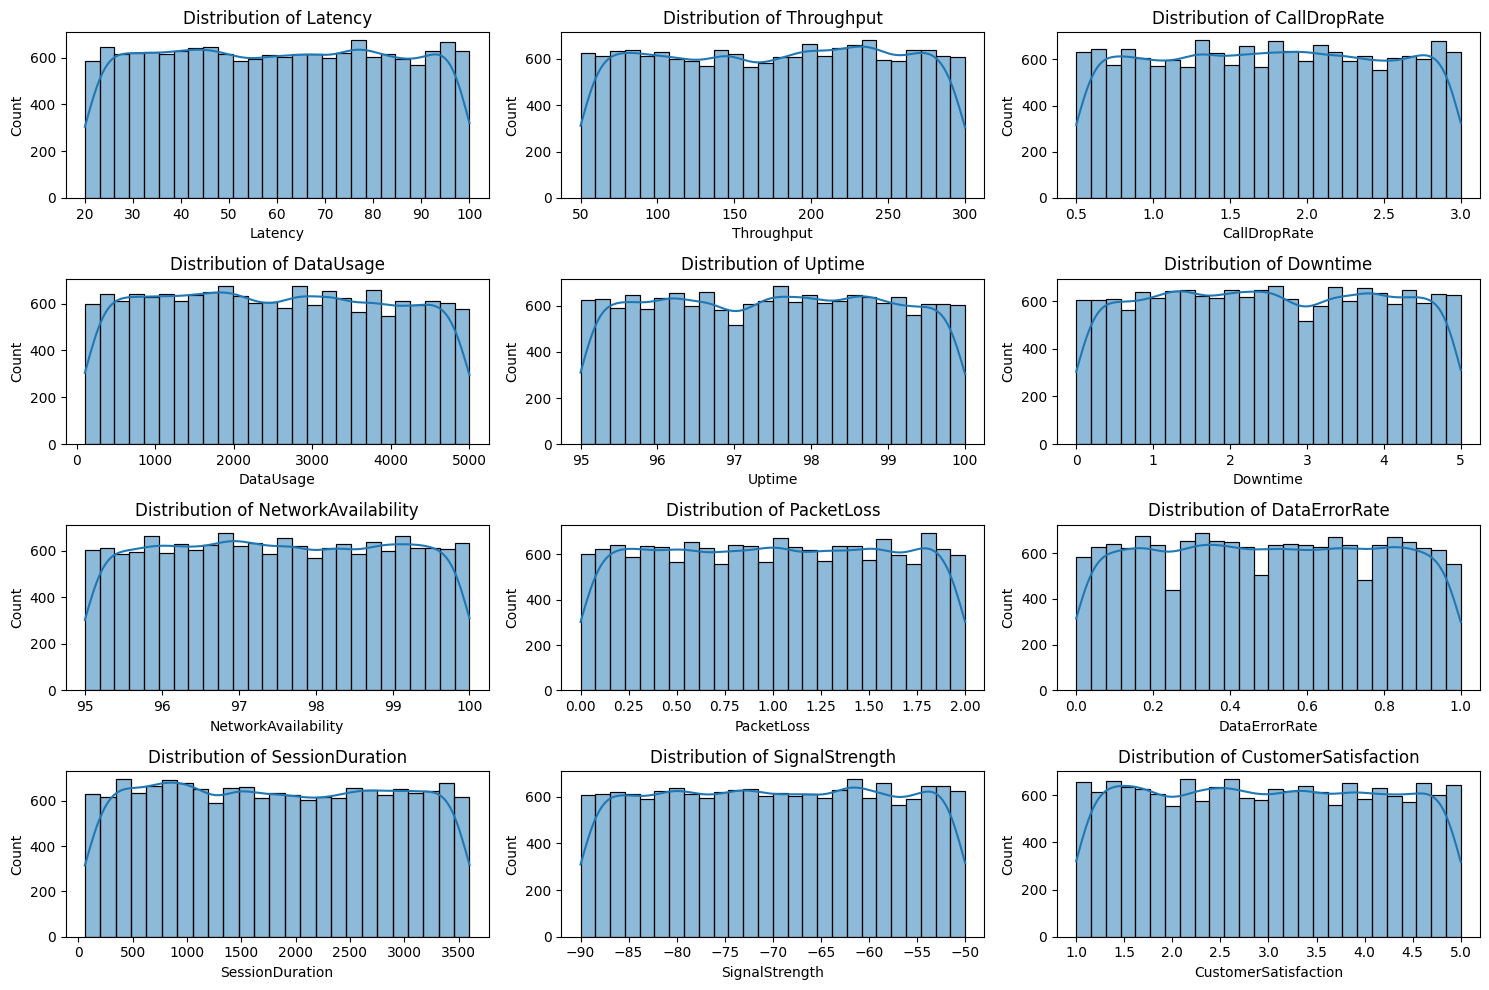

In [4]:
metrics = [
    'Latency', 
    'Throughput', 
    'CallDropRate', 
    'DataUsage', 
    'Uptime', 
    'Downtime', 
    'NetworkAvailability', 
    'PacketLoss', 
    'DataErrorRate', 
    'SessionDuration', 
    'SignalStrength', 
    'CustomerSatisfaction'
    ]

fig, axs = plt.subplots(4, 3, figsize=(15, 10))
axs = axs.flatten()
for i, col in enumerate(metrics):
    sns.histplot(df_fact[col], kde=True, ax=axs[i])
    axs[i].set_title(f"Distribution of {col}")
plt.tight_layout()
plt.show()

## Distribution of Latency
Range: ~20 ms to 100 ms
Shape: Uniform (flat) distribution
Interpretation:
Latency values are spread evenly from 20 to 100 ms.
In real networks, one might expect a more skewed or bell-shaped distribution (many events clustered around a certain latency with fewer high-latency spikes).
Because this is synthetic data, we see an even spread.

## Distribution of Throughput
Range: ~50 Mbps to 300 Mbps
Shape: Uniform distribution
Interpretation:
Throughput values range evenly from 50 to 300 Mbps.
Real-world throughput often follows more complex patterns (e.g., peak throughput at certain times). Here, it’s a simple demonstration of uniform sampling.

## Distribution of CallDropRate
Range: 0.5% to 3.0%
Shape: Uniform distribution
Interpretation:
Call drop rates are uniformly scattered between 0.5% and 3%.
Actual call drop rates are typically much lower (often well below 1%) and may have a more skewed distribution, but this synthetic range is just for demonstration.

## Distribution of DataUsage
Range: 100 MB to 5000 MB
Shape: Uniform distribution
Interpretation:
Data usage per record is evenly spread from 100 MB to 5 GB.
In real usage data, one might see a heavily skewed distribution (a large number of moderate users and a small number of very heavy users).

## Distribution of Uptime
Range: 95% to 100%
Shape: Uniform distribution
Interpretation:
Uptime is uniformly between 95% and 100%.
This indicates the network is mostly up, but the uniform spread is again due to random generation.
Real networks might show very high uptimes clustered near 100%, with occasional dips.

## Distribution of Downtime
Range: 0% to 5%
Shape: Uniform distribution
Interpretation:
Downtime is the complement of Uptime (100% - Uptime), so it ranges from 0% to 5%.
Similarly uniform, which is consistent with how we generated the data.
Real downtime data might be heavily skewed toward 0% (few outages) with rare spikes.

## Distribution of NetworkAvailability
Range: 95% to 100%
Shape: Uniform distribution
Interpretation:
Similar to Uptime, reflecting a random spread between 95% and 100%.
Real-world availability might be extremely high (near 99.9%) for most intervals, with short dips during outages.

## Distribution of PacketLoss
Range: 0% to 2%
Shape: Uniform distribution
Interpretation:
Packet loss events are uniformly spread in the 0–2% range.
Actual packet loss in many networks is typically near 0% most of the time, with spikes during congestion or link errors.

## Distribution of DataErrorRate
Range: 0% to 1%
Shape: Uniform distribution
Interpretation:
Data error rates spread evenly between 0% and 1%.
In reality, data errors might be very rare or concentrated in specific conditions (e.g., poor signal areas).

## Distribution of SessionDuration
Range: 60 seconds to 3600 seconds
Shape: Uniform distribution
Interpretation:
Session lengths vary uniformly from 1 minute to 1 hour.
Real session durations often have a skewed distribution, with many short sessions and fewer very long ones.

## Distribution of SignalStrength
Range: -90 dBm to -50 dBm
Shape: Uniform distribution
Interpretation:
Signal strength is uniformly distributed in this 40 dB window.
Real signal strength typically clusters around certain levels, influenced by tower distance, environment, and device power.

## Distribution of CustomerSatisfaction
Range: 1 (low) to 5 (high)
Shape: Uniform distribution
Interpretation:
Customer satisfaction ratings are evenly distributed between 1 and 5.
In actual surveys, one often see distributions skewed toward either high satisfaction (if the service is generally good) or some mixture of 1–2 (dissatisfied) and 4–5 (satisfied).

# Overall Interpretation

## Uniform Distributions
Each metric is generated from a uniform random distribution within a specified range. Hence, the histograms are relatively flat. This is not typically what real-world telecom data looks like, but it demonstrates the analysis workflow.

## Wide Ranges
Each variable covers a broad span (e.g., latency from 20–100 ms), illustrating the potential scope of network conditions.

## Synthetic Data Caution
Because this is synthetic, the takeaways about shape, skewness, and typical values won’t match a real production environment. In real data, one’d expect different shapes—often skewed or near‐normal distributions—reflecting actual usage patterns.

# Actionable Insights in a Real Scenario:

## Identify Skews or Clusters
In real data, one might discover that certain customers or times of day show much higher latency or usage.

## Plan Capacity
Uniformly high throughput usage might signal a need for consistent bandwidth, but real data could reveal peak hours.

## Targeted Improvements 
Knowing how metrics like PacketLoss or CallDropRate cluster can help network teams focus on areas with subpar performance.

## 2. Advanced Univariate Analysis

We perform additional tests on individual variables.
For example, we test for normality and detect outliers in Latency.


Normality test for Latency using Shapiro-Wilk test

In [5]:
stat, p = stats.shapiro(df_fact['Latency'])
print("Shapiro-Wilk test for Latency: stat=%.3f, p=%.3f" % (stat, p))

# Outlier detection using IQR for Latency
Q1 = df_fact['Latency'].quantile(0.25)
Q3 = df_fact['Latency'].quantile(0.75)
IQR = Q3 - Q1
outliers = df_fact[(df_fact['Latency'] < Q1 - 1.5 * IQR) | (df_fact['Latency'] > Q3 + 1.5 * IQR)]
print("Number of outliers in Latency:", outliers.shape[0])

Shapiro-Wilk test for Latency: stat=0.954, p=0.000
Number of outliers in Latency: 0


C:\Users\Kenn\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\scipy\stats\_axis_nan_policy.py:586: UserWarning: scipy.stats.shapiro: For N > 5000, computed p-value may not be accurate. Current N is 16053.
  res = hypotest_fun_out(*samples, **kwds)


**Inference from Advanced Univariate Analysis:**

## Shapiro-Wilk Test: stat=0.954, p=0.000

### What It Means
The p-value is effectively zero (well below 0.05), so the test strongly rejects the null hypothesis that Latency is normally distributed. In other words, the Latency data is not normally distributed.

### Why This Happens
If the data was generated from a uniform distribution, it will deviate significantly from a bell-shaped (normal) curve, thus leading to a very low p-value.

## Number of Outliers in Latency = 0

### What It Means 
Using the chosen outlier detection method (in this case, the Interquartile Range/IQR approach), there are no data points flagged as outliers for Latency.

### Why This Can Occur
A uniform distribution can spread values evenly across a range without producing extreme points that lie far outside the main data spread.
Even though the data is not normal, it may not have extreme outliers relative to the IQR boundaries (e.g., Q1 − 1.5×IQR, Q3 + 1.5×IQR).


## Combined Interpretation

### Non-Normal Distribution but No Outliers
These results indicate that while the Latency data does not follow a normal (bell-shaped) distribution, it also lacks extreme points that would be flagged as outliers by the IQR method. In practice:

#### Modeling Implications:

As we plan to use statistical methods that assume normality (e.g., certain parametric tests), we may need to transform the Latency data or switch to non-parametric methods.
A log or Box-Cox transformation might help if the data is skewed, but if it’s uniform, transformation may or may not be beneficial.

#### Operational Insight:

No extreme outliers suggest that the network’s Latency values are consistently within a certain range, with no unusual spikes detected by this method.
However, the lack of normality could mean the data is spread fairly evenly across a broad interval, which is consistent with uniform or near-uniform distributions.
Overall, these findings are typical when the data is synthetically generated (e.g., from a uniform distribution) and do not necessarily mimick real world scenarios.

The Shapiro-Wilk test will almost certainly show non-normality (p=0.000).
The uniform spread means no data points are far enough from the median to qualify as outliers under IQR-based detection.

## 3. Bivariate and Multivariate Analysis

We explore relationships between variables.
This includes correlation analysis (with significance tests), pair plots, and dimensionality reduction (PCA).

Pearson correlation test between Latency and CustomerSatisfaction

Pearson correlation (Latency vs. CustomerSatisfaction): r=-0.001, p=0.941


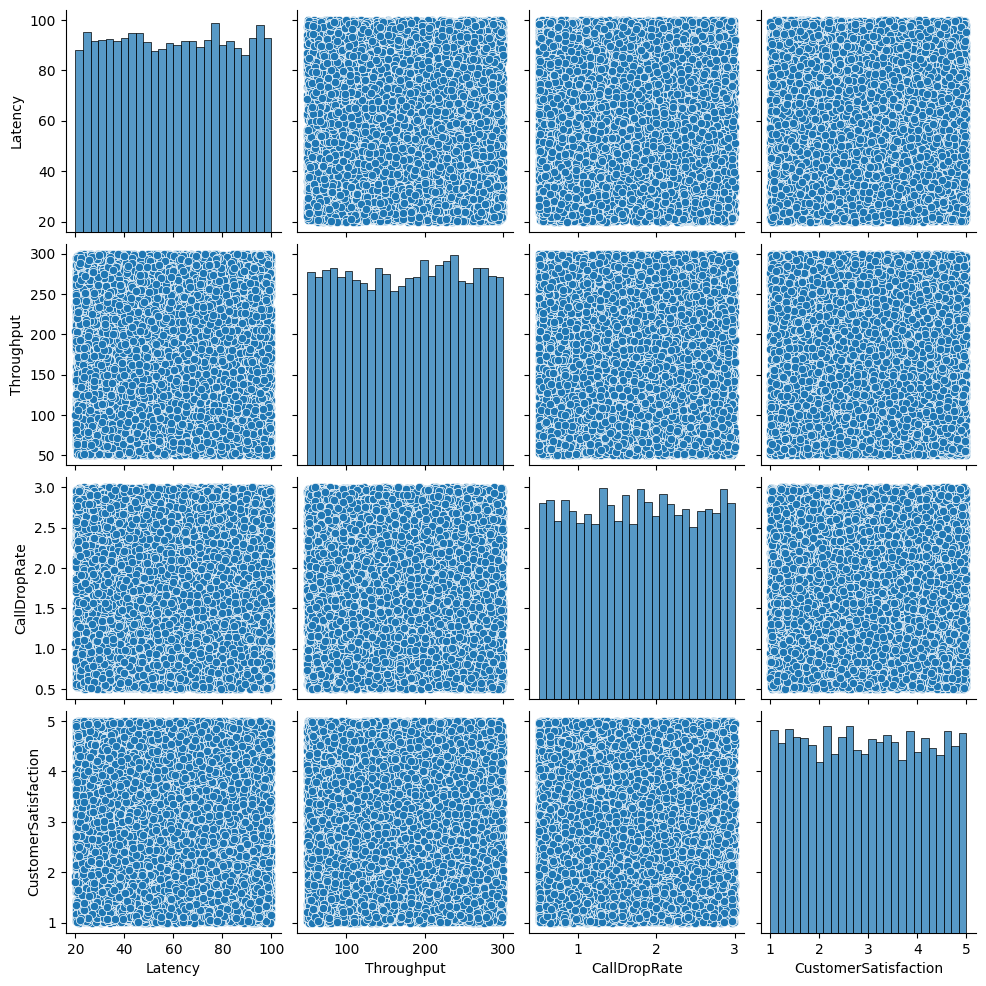

PCA Explained Variance Ratios: [0.99709079 0.00263851]


In [6]:
r, p_value = stats.pearsonr(df_fact['Latency'], df_fact['CustomerSatisfaction'])
print("Pearson correlation (Latency vs. CustomerSatisfaction): r=%.3f, p=%.3f" % (r, p_value))

# Scatterplot matrix
sns.pairplot(df_fact[['Latency', 'Throughput', 'CallDropRate', 'CustomerSatisfaction']])
plt.show()

# Principal Component Analysis (PCA)
features_for_pca = ['Latency', 'Throughput', 'CallDropRate', 'DataUsage']
pca = PCA(n_components=2)
principalComponents = pca.fit_transform(df_fact[features_for_pca])
print("PCA Explained Variance Ratios:", pca.explained_variance_ratio_)

**Inference from Bivariate & Multivariate Analysis:**

## Diagonal Histograms
Each diagonal plot shows the distribution of a single variable:

### Latency (top-left diagonal):

The bars are relatively flat from around 20 ms to 100 ms, indicating a uniform distribution.

### Throughput (second diagonal):

Ranges from ~50 Mbps to 300 Mbps.
Again, relatively flat, suggesting values are spread evenly in that interval.

### CallDropRate (third diagonal):

Uniformly ranges from 0.5% to 3%.

### CustomerSatisfaction (bottom-right diagonal):

Uniformly spans 1 (very unsatisfied) to 5 (very satisfied).

### Why They Look Uniform:

The data was randomly generated to be uniformly distributed within each variable’s range. Hence, no pronounced peaks or tails.

## Off-Diagonal Scatter Plots
Each off-diagonal cell shows a scatter plot comparing two variables:

Latency vs. Throughput, Latency vs. CallDropRate, Latency vs. CustomerSatisfaction, etc.
Throughput vs. CallDropRate, Throughput vs. CustomerSatisfaction, and so on.

### What they mean

The scatter points are spread fairly evenly, forming a “cloud” or “block” with no visible trend (like a linear slope or a curved pattern).
This uniform scatter suggests there is little to no correlation between these variables in the synthetic dataset.
<br>
In a Real Dataset:

One might see patterns such as a negative slope between Latency and CustomerSatisfaction (i.e., higher latency → lower satisfaction), or a positive slope between Throughput and Satisfaction.
Clustering or banding might appear if certain variables only take on specific ranges together (e.g., high throughput typically pairs with low latency).

## Key Takeaways
Uniform Distributions:
Each variable is drawn from a uniform range, leading to flat histograms on the diagonal.

No Apparent Correlation:
The off-diagonal scatter plots show no obvious relationship. In real data, we might expect negative or positive correlations (e.g., high latency usually lowers satisfaction).

## Why It Matters
Pair Plots Are Diagnostic:

They help quickly identify correlations (or lack thereof), outliers, and data distributions.
If one saw a diagonal line of points in any off-diagonal plot, that would indicate a strong relationship.

Actionable Insight in a Real Scenario:

One would use this analysis to determine which variables are strongly correlated (for predictive modeling) or to identify potential data quality issues (unexpected shapes, outliers).
Pair plots can guide feature selection, highlight interesting relationships, and prompt further investigation into why certain metrics are correlated.

## 4. Time Series Analysis & Forecasting

We analyze temporal trends in our data and forecast future DataUsage.
This section includes seasonal decomposition and autocorrelation analyses.

Aggregate daily metrics from the merged data

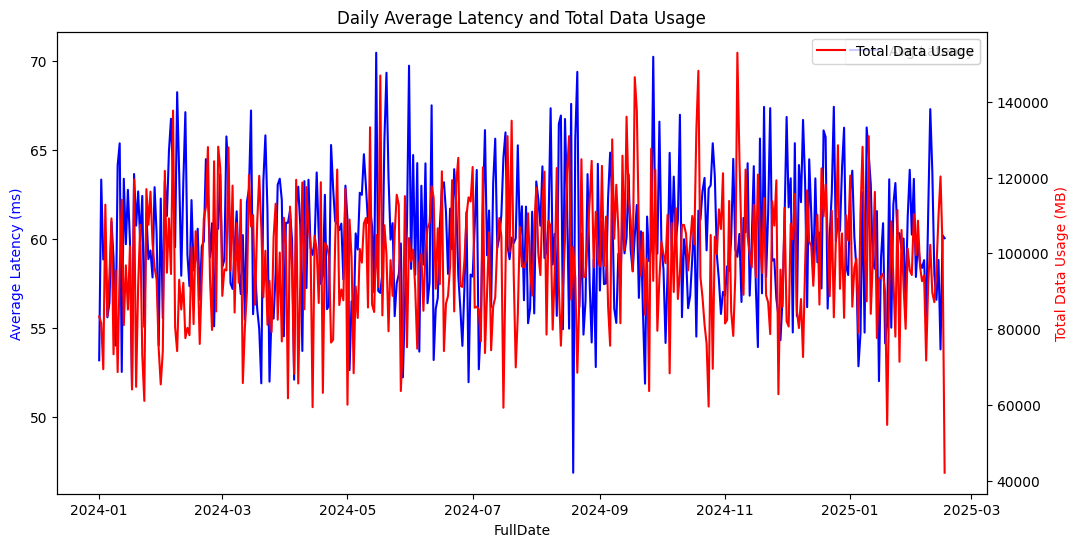

In [7]:
# Aggregate daily metrics from the merged data
daily_metrics = df_fact.groupby('FullDate').agg({
    'Latency': 'mean',
    'DataUsage': 'sum'
}).reset_index()

# Plot daily trends for latency and data usage
fig, ax1 = plt.subplots(figsize=(12, 6))
ax2 = ax1.twinx()
sns.lineplot(data=daily_metrics, x='FullDate', y='Latency', ax=ax1, color='blue', label='Avg Latency')
sns.lineplot(data=daily_metrics, x='FullDate', y='DataUsage', ax=ax2, color='red', label='Total Data Usage')
ax1.set_ylabel('Average Latency (ms)', color='blue')
ax2.set_ylabel('Total Data Usage (MB)', color='red')
plt.title("Daily Average Latency and Total Data Usage")
plt.xticks(rotation=45)
plt.show()

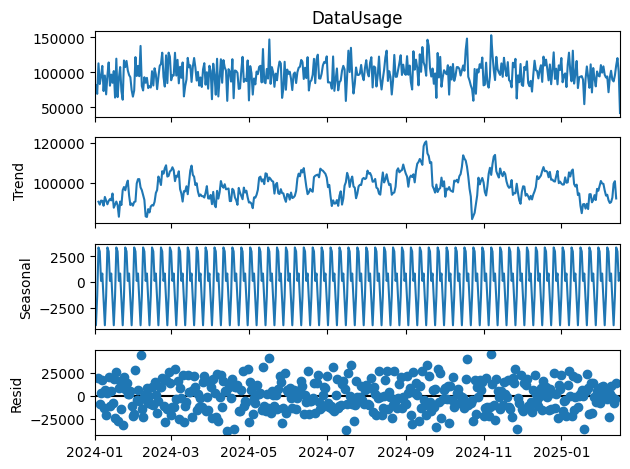

In [8]:
# Seasonal Decomposition of DataUsage
df_daily_usage = daily_metrics.set_index('FullDate')['DataUsage']
decomposition = seasonal_decompose(df_daily_usage, model='additive', period=7)
decomposition.plot()
plt.show()

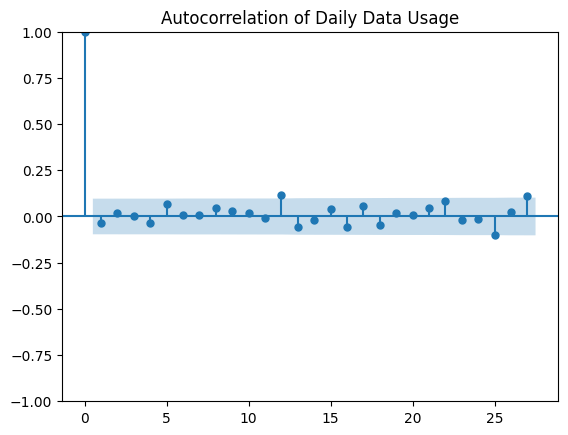

In [9]:
# Autocorrelation and Partial Autocorrelation
plot_acf(df_daily_usage)
plt.title("Autocorrelation of Daily Data Usage")
plt.show()

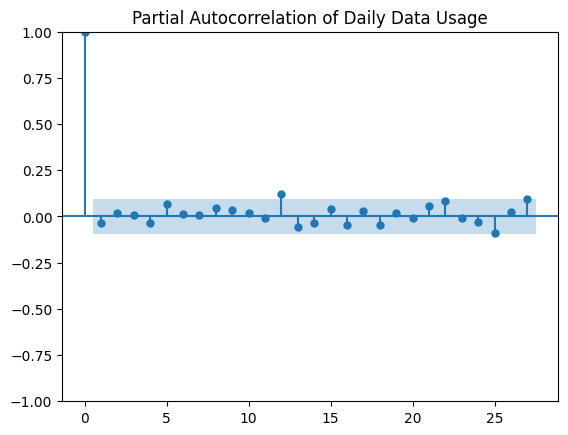

In [10]:
plot_pacf(df_daily_usage)
plt.title("Partial Autocorrelation of Daily Data Usage")
plt.show()

### Time Series Forecasting with Prophet

We forecast total data usage for the next 30 days. Prophet is widely used in industry for its ease-of-use and robustness.

16:20:17 - cmdstanpy - INFO - Chain [1] start processing
16:20:17 - cmdstanpy - INFO - Chain [1] done processing


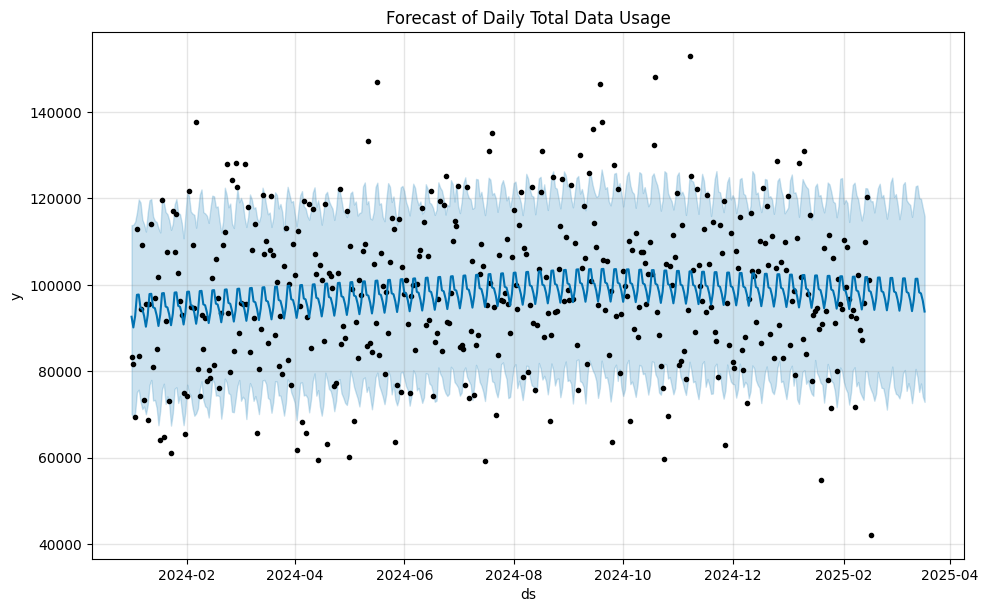

In [11]:
# Prepare data for Prophet
df_prophet = daily_metrics[['FullDate', 'DataUsage']].rename(columns={'FullDate': 'ds', 'DataUsage': 'y'})
m_prophet = Prophet(daily_seasonality=True)
m_prophet.fit(df_prophet)

# Create a dataframe to hold predictions
future = m_prophet.make_future_dataframe(periods=30)
forecast = m_prophet.predict(future)

# Plot the forecast
fig1 = m_prophet.plot(forecast)
plt.title("Forecast of Daily Total Data Usage")
plt.show()

**Inference from Time Series Analysis:**

- Seasonal decomposition and ACF/PACF plots reveal underlying trends and periodicity in DataUsage.
- Forecasting with Prophet helps anticipate future network load.

## 5. Statistical Hypothesis Testing

We perform hypothesis tests to validate observed differences.
For example, we test whether customer satisfaction differs between two groups defined by high vs. low latency.

In [12]:
# Create groups based on median latency
df_fact['LatencyGroup'] = np.where(df_fact['Latency'] > df_fact['Latency'].median(), 'HighLatency', 'LowLatency')
group_high = df_fact[df_fact['LatencyGroup'] == 'HighLatency']['CustomerSatisfaction']
group_low = df_fact[df_fact['LatencyGroup'] == 'LowLatency']['CustomerSatisfaction']

stat, p = stats.ttest_ind(group_high, group_low, equal_var=False)
print("T-test (HighLatency vs. LowLatency) on CustomerSatisfaction: stat=%.3f, p=%.3f" % (stat, p))

# Chi-Square test example: if we had categorical clusters and regions
# For demonstration, assume a dummy categorical variable exists.
contingency_table = pd.crosstab(df_fact['LatencyGroup'], df_fact['NetworkTypeID'])
chi2, p_chi, dof, expected = stats.chi2_contingency(contingency_table)
print("Chi-Square test: chi2=%.3f, p=%.3f" % (chi2, p_chi))

T-test (HighLatency vs. LowLatency) on CustomerSatisfaction: stat=-0.346, p=0.730
Chi-Square test: chi2=1.087, p=0.581


**Inference from Hypothesis Testing:**

- T-tests help determine if differences in customer satisfaction between groups are statistically significant.
- Chi-Square tests validate associations between categorical variables.

**Actionable Insight:**  
Statistical tests provide confidence in observed differences, guiding targeted interventions.

## 6. Feature Engineering & Data Transformation

We refine our features to improve model performance.
For example, we apply a logarithmic transformation to reduce skewness in DataUsage.

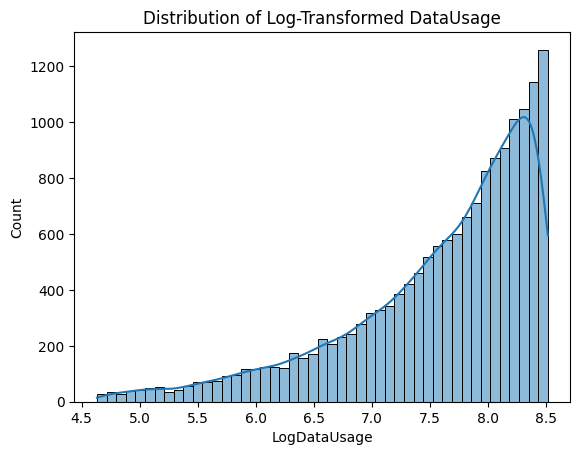

In [13]:
df_fact['LogDataUsage'] = np.log(df_fact['DataUsage'] + 1)
sns.histplot(df_fact['LogDataUsage'], kde=True)
plt.title("Distribution of Log-Transformed DataUsage")
plt.show()

**Inference from Feature Engineering:**

- Transformations can help normalize distributions and stabilize variance.

**Actionable Insight:**  
Use transformed features in predictive models to improve accuracy and robustness.


##  7. Advanced Predictive Modeling & Experiment Tracking

 We build a predictive model for CustomerSatisfaction using a pipeline with scaling and Random Forest.
 Hyperparameter tuning is performed via GridSearchCV and experiments are logged with MLflow.


In [14]:
# Define features and target
features = ['Latency', 'Throughput', 'CallDropRate', 'DataUsage', 'PacketLoss', 'Jitter', 'NetworkAvailability']
target = 'CustomerSatisfaction'

df_model = df_fact[features + [target]].dropna()

X = df_model[features]
y = df_model[target]

# Split data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Create a modeling pipeline with scaling and RandomForest
pipeline = Pipeline([
    ('scaler', StandardScaler()),
    ('rf', RandomForestRegressor(random_state=42))
])

# Set up hyperparameter tuning
param_grid = {
    'rf__n_estimators': [50, 100],
    'rf__max_depth': [None, 10, 20]
}

grid_search = GridSearchCV(pipeline, param_grid, cv=3, scoring='neg_mean_squared_error')

# Start MLflow experiment tracking (ensure mlflow is configured in your environment)
mlflow.set_experiment("Telecom_Customer_Satisfaction_Prediction")

with mlflow.start_run():
    grid_search.fit(X_train, y_train)
    best_model = grid_search.best_estimator_
    y_pred = best_model.predict(X_test)
    mse = mean_squared_error(y_test, y_pred)
    print("Best Model MSE:", mse)
    
    # Log parameters and metrics to MLflow
    mlflow.log_params(grid_search.best_params_)
    mlflow.log_metric("MSE", mse)
    mlflow.sklearn.log_model(best_model, "model")

    # Feature importance (from RandomForest)
    importances = best_model.named_steps['rf'].feature_importances_
    importance_df = pd.DataFrame({'Feature': features, 'Importance': importances})
    print("\nFeature Importances:")
    print(importance_df.sort_values(by='Importance', ascending=False))

Best Model MSE: 1.3443242560470259


2025/02/16 16:21:41 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.



Feature Importances:
               Feature  Importance
1           Throughput    0.161188
5               Jitter    0.151579
0              Latency    0.146327
3            DataUsage    0.145683
6  NetworkAvailability    0.134903
2         CallDropRate    0.130598
4           PacketLoss    0.129723


**Inference from Predictive Modeling:**
- The model’s feature importances highlight which network metrics most affect customer satisfaction.

**Actionable Insight:**  
Prioritize reducing the most impactful factors (e.g., high latency or call drop rate) to improve overall satisfaction.

**Note:** In a large-scale setting, you’d deploy and retrain this model regularly using MLOps practices.

## 4. Enhanced Clustering and Segmentation

We segment customers using K-Means clustering.
The silhouette score helps determine the optimal number of clusters.

In production, advanced clustering algorithms and feature engineering are used for precise segmentation.

%%

In [15]:
# Use selected features for clustering
cluster_features = ['DataUsage', 'NumberOfCalls', 'SessionDuration', 'CustomerSatisfaction', 'ARPU']
df_cluster = df_fact[cluster_features].copy()

# Normalize features
df_cluster_norm = (df_cluster - df_cluster.min()) / (df_cluster.max() - df_cluster.min())

# Determine optimal number of clusters using silhouette score
sil_scores = []
for k in range(2, 7):
    kmeans = KMeans(n_clusters=k, random_state=42)
    labels = kmeans.fit_predict(df_cluster_norm)
    score = silhouette_score(df_cluster_norm, labels)
    sil_scores.append(score)
    print(f"Silhouette score for {k} clusters: {score:.3f}")

optimal_clusters = np.argmax(sil_scores) + 2
print("Optimal number of clusters:", optimal_clusters)

# Apply clustering with optimal clusters
kmeans = KMeans(n_clusters=optimal_clusters, random_state=42)
df_fact['Cluster'] = kmeans.fit_predict(df_cluster_norm)

cluster_summary = df_fact.groupby('Cluster')[cluster_features + ['CustomerSatisfaction', 'ARPU']].mean()
print("\nCluster Summary:")
print(cluster_summary)

Silhouette score for 2 clusters: 0.149
Silhouette score for 3 clusters: 0.135
Silhouette score for 4 clusters: 0.140
Silhouette score for 5 clusters: 0.145
Silhouette score for 6 clusters: 0.151
Optimal number of clusters: 6

Cluster Summary:
           DataUsage  NumberOfCalls  SessionDuration  CustomerSatisfaction  \
Cluster                                                                      
0        3823.058479      16.448089      2688.559798              2.700627   
1        1640.955156      20.068389      1346.272340              2.187340   
2        3423.973956      37.001137      1102.445426              3.764066   
3        2347.247785      36.579271      1905.738369              1.974392   
4        2357.042286      11.700395      1141.658120              3.346200   
5        1475.409151      28.697248      2750.006644              3.953582   

              ARPU  CustomerSatisfaction       ARPU  
Cluster                                              
0        61.999362      

**Inference from Clustering:**
- The clusters can represent distinct customer segments (e.g., high usage vs. low usage).

**Actionable Insight:**  
Tailor customer support, marketing, and service plans for each segment to improve retention and revenue.

## 5. Anomaly Detection and Impact Analysis

We use an Isolation Forest model to detect anomalies in network performance and analyze their impact on customer satisfaction and revenue.

Number of detected anomalies: 803


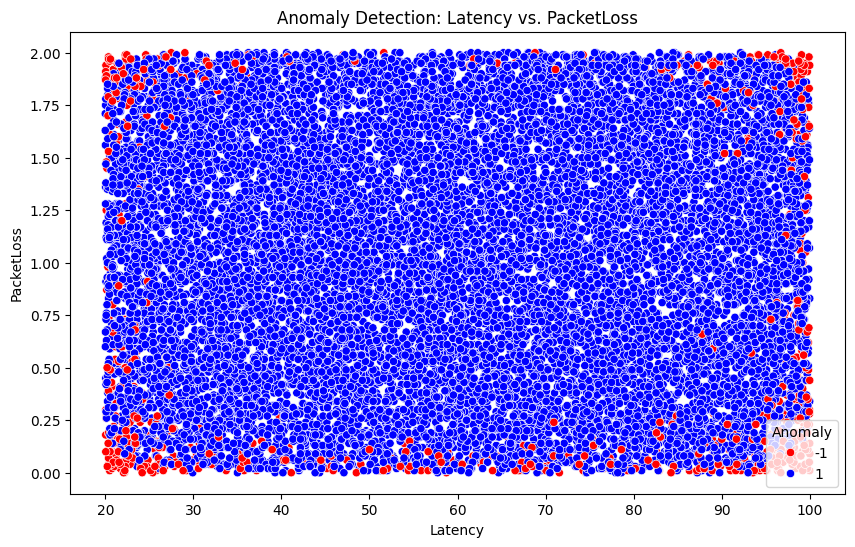

Impact Summary by Downtime:
  DowntimeBin  CustomerSatisfaction     Revenue  ComplaintRate
0         Low              3.001922  506.639719       2.539709
1    Moderate              3.007430  509.501202       2.514502
2        High              2.965081  507.759191       2.511393


C:\Users\Kenn\AppData\Local\Temp\ipykernel_37948\4175808391.py:17: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  impact_summary = df_fact.groupby('DowntimeBin').agg({


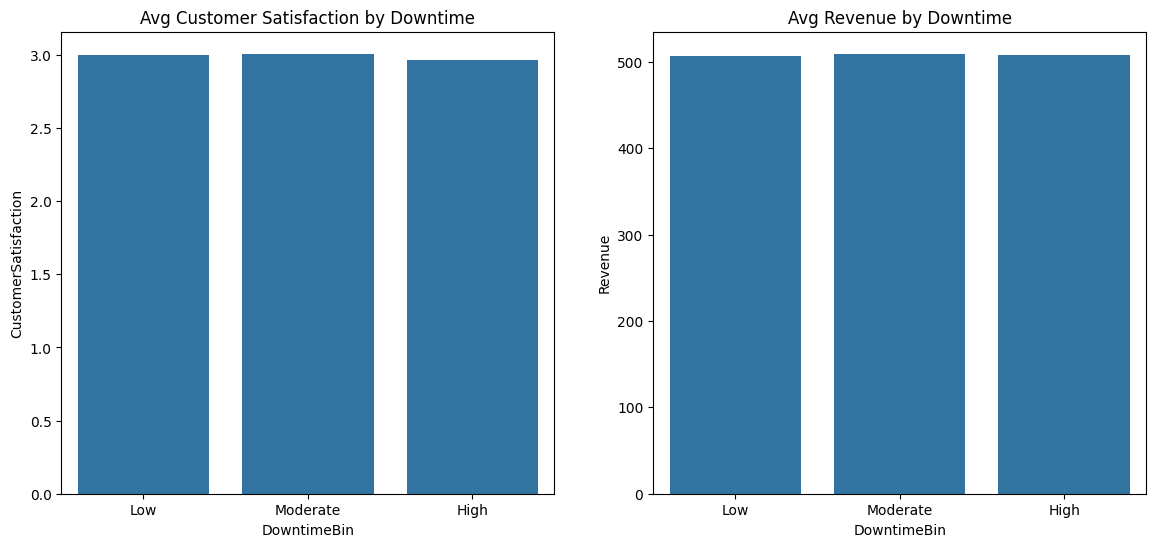

In [16]:
anomaly_features = ['Latency', 'PacketLoss', 'Jitter']
X_anomaly = df_fact[anomaly_features]

iso_forest = IsolationForest(contamination=0.05, random_state=42)
df_fact['Anomaly'] = iso_forest.fit_predict(X_anomaly)
anomalies = df_fact[df_fact['Anomaly'] == -1]
print("Number of detected anomalies:", anomalies.shape[0])

# Visualize anomalies
plt.figure(figsize=(10, 6))
sns.scatterplot(data=df_fact, x='Latency', y='PacketLoss', hue='Anomaly', palette={1:'blue', -1:'red'})
plt.title("Anomaly Detection: Latency vs. PacketLoss")
plt.show()

# Impact analysis: Bin downtime and observe effects on satisfaction and revenue
df_fact['DowntimeBin'] = pd.cut(df_fact['Downtime'], bins=[0, 1, 3, 5], labels=['Low', 'Moderate', 'High'])
impact_summary = df_fact.groupby('DowntimeBin').agg({
    'CustomerSatisfaction': 'mean',
    'Revenue': 'mean',
    'ComplaintRate': 'mean'
}).reset_index()
print("Impact Summary by Downtime:")
print(impact_summary)

fig, ax = plt.subplots(1, 2, figsize=(14, 6))
sns.barplot(data=impact_summary, x='DowntimeBin', y='CustomerSatisfaction', ax=ax[0])
ax[0].set_title("Avg Customer Satisfaction by Downtime")
sns.barplot(data=impact_summary, x='DowntimeBin', y='Revenue', ax=ax[1])
ax[1].set_title("Avg Revenue by Downtime")
plt.show()

**Inference from Anomaly & Impact Analysis:**
- Anomalies could indicate network issues that lead to poor customer experience.
- High downtime correlates with lower satisfaction and revenue.

**Actionable Insight:**  
Implement real-time anomaly detection and robust recovery protocols to mitigate the impact of network disruptions.

## 6. Interactive Dashboard Prototyping
 
Finally, we create an interactive dashboard for monitoring key metrics using Plotly.
In an enterprise environment, such dashboards are integrated into operational workflows and updated in real time.

In [17]:
daily_usage = df_fact.groupby('FullDate')['DataUsage'].sum().reset_index()

fig = px.line(daily_usage, x='FullDate', y='DataUsage', title='Daily Total Data Usage',
              labels={'FullDate': 'Date', 'DataUsage': 'Total Data Usage (MB)'})
fig.update_xaxes(rangeslider_visible=True)
fig.show()